In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
from proj1_helpers import load_csv_data, predict_labels, create_csv_submission
from implementations import least_squares_GD, least_squares_SGD, ridge_regression, ridge_GD, ridge_SGD, logistic_regression, reg_logistic_regression
from preprocessing import standardize_train, standardize_test, add_bias
from losses_gradients import sigmoid, compute_loss_ls, compute_loss_ridge, compute_logreg_loss, compute_logreg_grad, compute_logreg_reg_loss, compute_logreg_reg_grad
from plots import plot_train_test
import math

## Load data

In [3]:
y_train, input_train, ids_train = load_csv_data('train.csv', sub_sample=False)
y_test, input_test, ids_test = load_csv_data('test.csv', sub_sample=False)

## Pre-processing

In [4]:
# Standardise data
# Careful to standardize the x_test with the mean and std of x_train
x_train, mean, std = standardize_train(input_train)
x_train = add_bias(x_train)
x_test = standardize_test(input_test, mean, std)
x_test = add_bias(x_test)

In [5]:
x_train.shape[0]

250000

## Constant definitions

In [61]:
nb_fold = 5

In [62]:
# Define the parameters of the algorithm. (probably change afterwards)
max_iters = 1000   #les plots sont moches parce que j'ai fait avec 20 ici                                  
batch_size = 1

# Initialization
w_initial = np.random.rand(x_train.shape[1])

In [63]:
# For grid search of hyperparameters
num_intervals = 15
#gammas = np.linspace(0, 0.20, num_intervals)
gammas = np.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.5])
lambdas = np.logspace(-4, -0.05, num_intervals)

## GD Least squares

In [64]:
def ls_gd_hyperparam(gammas, nb_fold, x_train, y_train):
    loss_valid = np.zeros([len(gammas), nb_fold])
    loss_train = np.zeros([len(gammas), nb_fold])
    
    nb_elem = math.floor(x_train.shape[0]/nb_fold)
    
    for i, gamma in enumerate(gammas):
        for k in range(nb_fold):
            x_valid_k = x_train[k*nb_elem:(k+1)*nb_elem][:]  
            y_valid_k = y_train[k*nb_elem:(k+1)*nb_elem]
            
            x_train_k = np.concatenate([x_train[0:k*nb_elem][:], x_train[(k+1)*nb_elem:][:]])
            y_train_k = np.concatenate([y_train[0:k*nb_elem],    y_train[(k+1)*nb_elem:]   ]) 
                                        
            w, loss_tr = least_squares_GD(y_train_k, x_train_k, w_initial, max_iters, gamma)
            loss_train[i][k] = loss_tr
            loss_valid[i][k] = compute_loss_ls(y_valid_k, x_valid_k, w)
            
    return loss_valid, loss_train 

In [65]:
loss_valid_gd, loss_train_gd = ls_gd_hyperparam(gammas, nb_fold, x_train, y_train)

In [66]:
train_gd_mean = np.mean(loss_train_gd, axis=1)
valid_gd_mean = np.mean(loss_valid_gd, axis=1)

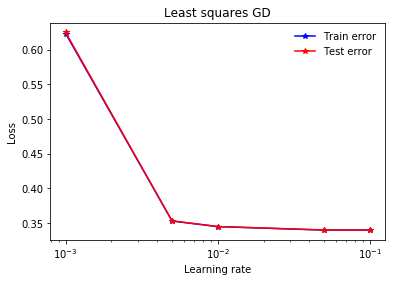

In [67]:
#Schéma moche parce que nb_iter bien trop faible
plot_train_test(train_gd_mean, valid_gd_mean, gammas, "Least squares GD")

In [68]:
# Minimum values for ls_gd
idx = np.argmin(valid_gd_mean)
learning_rate = gammas[idx]
ls_gd_loss = np.min(valid_gd_mean)
print(learning_rate)
print(ls_gd_loss)

0.5
nan


# SGD Least squares

In [22]:
def ls_sgd_hyperparam(gammas, nb_fold, x_train, y_train):
    loss_valid = np.zeros([len(gammas), nb_fold])
    loss_train = np.zeros([len(gammas), nb_fold])
    
    nb_elem = math.floor(x_train.shape[0]/nb_fold)
    
    for i, gamma in enumerate(gammas):
        for k in range(nb_fold):
            x_valid_k = x_train[k*nb_elem:(k+1)*nb_elem][:]  
            y_valid_k = y_train[k*nb_elem:(k+1)*nb_elem]
            
            x_train_k = np.concatenate([x_train[0:k*nb_elem][:], x_train[(k+1)*nb_elem:][:]])
            y_train_k = np.concatenate([y_train[0:k*nb_elem],    y_train[(k+1)*nb_elem:]   ]) 
                                        
            w, loss_tr = least_squares_SGD(y_train_k, x_train_k, w_initial, max_iters, gamma)
            loss_train[i][k] = loss_tr
            loss_valid[i][k] = compute_loss_ls(y_valid_k, x_valid_k, w)
            
    return loss_valid, loss_train 

In [23]:
loss_valid_sgd, loss_train_sgd = ls_sgd_hyperparam(gammas, nb_fold, x_train, y_train)

KeyboardInterrupt: 

In [ ]:
train_sgd_mean = np.mean(loss_train_sgd, axis=1)
valid_sgd_mean = np.mean(loss_valid_sgd, axis=1)

In [ ]:
plot_train_test(train_sgd_mean, valid_sgd_mean, gammas, "Least squares SGD")

In [ ]:
# Minimum values for ls_sgd
idx = np.argmin(valid_sgd_mean)
learning_rate = gammas[idx]
ls_sgd_loss = np.min(valid_sgd_mean)
print(learning_rate)
print(ls_sgd_loss)

## SGD Ridge regression

Peut etre trop long, plutot voir si on pose un 'bon' gamma, quel est le meilleur lambda.

Du coup, même fonction que avant pour hyperparam

In [29]:
def ridge_sgd_hyperparam(gammas, lambdas, nb_fold, x_train, y_train):
    loss_train = np.zeros([len(gammas), len(lambdas), nb_fold])
    loss_valid = np.zeros([len(gammas), len(lambdas), nb_fold])
    
    nb_elem = math.floor(x_train.shape[0]/nb_fold)
    
    for i, gamma in enumerate(gammas):
        for j, lambda_ in enumerate(lambdas):
            for k in range(nb_fold):
                x_valid_k = x_train[k*nb_elem:(k+1)*nb_elem][:]  
                y_valid_k = y_train[k*nb_elem:(k+1)*nb_elem]

                x_train_k = np.concatenate([x_train[0:k*nb_elem][:], x_train[(k+1)*nb_elem:][:]])
                y_train_k = np.concatenate([y_train[0:k*nb_elem],    y_train[(k+1)*nb_elem:]   ]) 

                w, loss_gamma = ridge_SGD(y_train_k, x_train_k, w_initial, max_iters, gamma, lambda_)
                loss_train[i][j][k] = loss_gamma
                loss_valid[i][j][k]  = compute_loss_ridge(y_valid_k, x_valid_k, w, lambda_)
                print("fold {}  ".format(k))
            print("lambda {}\n".format(j))
        print("gamma {} \n \n".format(i))
    return loss_train, loss_valid

In [30]:
loss_valid_r_sgd, loss_train_r_sgd = ridge_sgd_hyperparam(gammas, lambdas, nb_fold, x_train, y_train)

In [31]:
train_sgd_mean = np.mean(loss_train_r_sgd, axis=2)
valid_sgd_mean = np.mean(loss_valid_r_sgd, axis=2)

In [40]:
loss_valid_r_sgd[0][0]

array([21.46712264, 21.51827889, 21.48912951, 21.55624567, 21.49695642])

Text(0.5,0,'Loss')

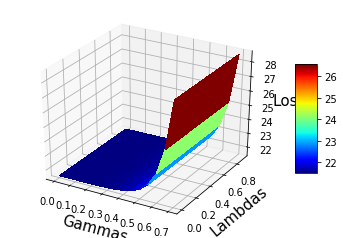

In [44]:
# TODO: Plot 2D à coder   TO TEST
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FixedLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')
X = gammas
Y = lambdas
X, Y = np.meshgrid(X, Y)
Z = valid_sgd_mean
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.jet,
        linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_xlabel('Gammas', fontsize=15)
ax.set_ylabel('Lambdas', fontsize=15)
ax.set_zlabel('Loss', fontsize=15)
#plt.savefig('hyperparam.png')

In [ ]:
# Minimum values for ls_sgd
ind = np.unravel_index(np.argmin(valid_sgd_mean, axis=None), valid_sgd_mean.shape)
learning_rate = gammas[ind[0]]
ls_sgd_loss = valid_sgd_mean[ind]
print(learning_rate)
print(ls_sgd_loss)

## GD Ridge regression

In [ ]:
def ridge_gd_hyperparam(gammas, lambdas, nb_fold, x_train, y_train):
    loss_train = np.zeros([len(gammas), len(lambdas), nb_fold])
    loss_valid = np.zeros([len(gammas), len(lambdas), nb_fold])
    
    nb_elem = math.floor(x_train.shape[0]/nb_fold)
    
    for i, gamma in enumerate(gammas):
        for j, lambda_ in enumerate(lambdas):
            for k in range(nb_fold):
                
                x_valid_k = x_train[k*nb_elem:(k+1)*nb_elem][:]  
                y_valid_k = y_train[k*nb_elem:(k+1)*nb_elem]

                x_train_k = np.concatenate([x_train[0:k*nb_elem][:], x_train[(k+1)*nb_elem:][:]])
                y_train_k = np.concatenate([y_train[0:k*nb_elem],    y_train[(k+1)*nb_elem:]   ]) 

                w, loss_gamma = ridge_SGD(y_train_k, x_train_k, w_initial, max_iters, gamma, lambda_)
                loss_train[i][j][k] = loss_gamma
                loss_valid[i][j][k] = compute_loss_ridge(y_valid_k, x_valid_k, w, lambda_)
                
    return loss_train, loss_valid

In [ ]:
loss_valid_r_gd, loss_train_r_gd = ridge_gd_hyperparam(gammas, lambdas, nb_fold, x_train, y_train)

In [ ]:
train_gd_mean = np.mean(loss_train_r_gd, axis=2)
valid_gd_mean = np.mean(loss_valid_r_gd, axis=2)

In [ ]:
# Minimum values for ls_sgd
ind = np.unravel_index(np.argmin(valid_gd_mean, axis=None), valid_gd_mean.shape)
learning_rate = gammas[ind[0]]
ls_gd_loss = valid_gd_mean[ind]
print(learning_rate)
print(ls_gd_loss)

# Pas sûre des logistic regression. Voir correction lab05
Sinon toujours le même code et techniques que avant 

## Logistic regression
Debugged but not sure from here: Il y aura probablement une correction du labo 5 pour améliorer / vérifier les fonctions de logistic regression

## Regularized Logistic Regression

# Prediction de chaque méthode pour Kaggle

In [ ]:
y_pred = predict_labels(w, x_test)